# 수입 화물 우범도 예측 모델 개발


## 0. 기본 모듈 및 함수 import 

In [1]:
# 모델 구현 시간 체크
import time
# 시작시간 체크
start = time.time()

In [2]:
# 패키지 로딩
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 한글폰트 적용
plt.rc('font', family='NanumGothicOTF') # For MacOS
# plt.rc('font', family='NanumGothic') # For Windows
print(plt.rcParams['font.family'])


['NanumGothicOTF']


In [4]:
# 분석 차트 그리는 함수 목록

def show_pie_chart(df, col_name):
    colname_survived = survived_crosstab(df, col_name)
    pie_chart(colname_survived)
    return colname_survived

def survived_crosstab(df, col_name):
    '''col_name과 Survived간의 교차도표 생성'''
    feature_survived = pd.crosstab(df[col_name], df['우범여부'])
    feature_survived.columns = feature_survived.columns.map({0:"정상", 1:"우범"})
    return feature_survived

def pie_chart(feature_survived):
    '''
    pie_chart 생성
    pcol, prow = 차트를 출력할 개수. pcol * prow 만큼의 차트 출력 
    '''
    frows, fcols = feature_survived.shape
    pcol = 3
    prow = (frows/pcol + frows%pcol)
    plot_height = prow * 2.5
    plt.figure(figsize=(8, plot_height))

    for row in range(0, frows):
        plt.subplot(prow, pcol, row+1)

        index_name = feature_survived.index[row]
        plt.pie(feature_survived.loc[index_name], labels=feature_survived.loc[index_name].index, autopct='%1.1f%%')
        plt.title("{0}' 우범".format(index_name))

    plt.show()

## 1. 전처리 

In [5]:
# train data load
df = pd.read_csv('./data/train.csv')

In [6]:
# test data load
df_test = pd.read_excel('./data/test.xlsx')

In [7]:
# train data size 확인 
df.shape

(76837, 24)

In [8]:
# test data size 확인 
df_test.shape

(23163, 21)

## 정상 및 우범 비율 

In [9]:
crime = np.sum(df['우범여부'] == 1) 
print('crime : {}'.format(crime))
normal = np.sum(df['우범여부'] == 0)

normal2 = np.sum(df['핵심적발'] == 0)
print('normal2 : {}'.format(normal2))
print('normal : {}'.format(normal))
normal_crime = np.sum(df['핵심적발'] == 1)
print('normal crime : {}'.format(normal_crime))
principal_crime = np.sum(df['핵심적발'] == 2)
print('principal crime : {}'.format(principal_crime))
print('crime = normal crime + principal crime = {} = {} + {}'
      .format(crime,normal_crime,principal_crime))
print('우범 : 정상')
print("{} :  {}".format(1,round(normal / crime)))

crime : 17572
normal2 : 59265
normal : 59265
normal crime : 8523
principal crime : 9049
crime = normal crime + principal crime = 17572 = 8523 + 9049
우범 : 정상
1 :  3


## Nan check

In [10]:
# train data 
df.isnull().sum()

신고번호            0
신고일자            0
통관지세관부호         0
신고인부호           0
수입자부호           8
해외거래처부호     26293
특송업체부호      51731
수입통관계획코드        0
수입신고구분코드        0
수입거래구분코드        0
수입종류코드          0
징수형태코드          0
신고중량(KG)        0
과세가격원화금액        0
운송수단유형코드        0
반입보세구역부호        0
HS10단위부호        0
적출국가코드          0
원산지국가코드         0
관세율구분코드         0
관세율             0
검사결과코드          0
우범여부            0
핵심적발            0
dtype: int64

In [11]:
# test data 
df_test.isnull().sum()

신고번호            0
신고일자            0
통관지세관부호         0
신고인부호           0
수입자부호           1
해외거래처부호      7674
특송업체부호      15430
수입통관계획코드        0
수입신고구분코드        0
수입거래구분코드        0
수입종류코드          0
징수형태코드          0
신고중량(KG)        0
과세가격원화금액        0
운송수단유형코드        0
반입보세구역부호        0
HS10단위부호        0
적출국가코드          0
원산지국가코드         0
관세율구분코드         0
관세율             0
dtype: int64

## 불필요한 변수 삭제

In [12]:
del df['검사결과코드']
del df['핵심적발']

## 1. 신고일자

### 1.1 일로 범주화.


In [13]:
## 훈련 데이터 신고일 추출
df['신고일자'] = pd.to_datetime(df['신고일자'])
df['신고일'] = df['신고일자'].dt.day

In [14]:
# 테스트 데이터 신고일자 전처리
df_test['신고일자'] = pd.to_datetime(df_test['신고일자'])
df_test['신고일'] = df_test['신고일자'].dt.day

### 1.2 요일 범주화

In [15]:
# 훈련데이터 요일 0 월요일 ~ 6 일요일
df['신고요일'] = df['신고일자'].dt.weekday

In [16]:
df['신고요일'].sample(5)

18158    2
10103    4
9941     3
43329    1
32130    1
Name: 신고요일, dtype: int64

In [17]:
# 테스트 데이터 요일 0 월요일 ~ 6 일요일
df_test['신고요일'] = df_test['신고일자'].dt.weekday

In [18]:
df_test['신고요일'].sample(5)

22089    0
12127    4
21746    3
14601    5
5316     4
Name: 신고요일, dtype: int64

In [19]:
# test data 불필요한 칼럼 제거
del df_test['신고번호']
del df_test['신고일자']
del df_test['신고인부호']
del df_test['수입자부호']

In [20]:
# 불필요한 훈련 데이터 column 제거 
del df['신고번호']
del df['신고일자']
del df['신고인부호']
del df['수입자부호']

## 2. 통관지세관부호

- 통관지세관부호와 우범여부와의 관계를 알아본다.



- 통관지세관부호의 class는 총 40개


## 3. 신고인부호

- 수입신고를 하는 자로 대개는 관세사가 됨(대리하여 신고)


- 우범 전력이 있는지 없는지를 counting하고 그 count 값을 새로운 feature로 생성

## 4. 수입자부호

- 물품을 수입하는 실제 화주(물건 주인)


- 8000여개


## 5. 해외거래처부호

- 물품을 거래하는 해외 상대방 거래처 부호


- 4748개


- 가상 데이터이기때문에 기존 부호의 양식과 일치하지 않는다.


- Null 값은 U(Unknown)으로 채움

In [21]:
df.해외거래처부호 = df.해외거래처부호.fillna('U')

In [22]:
df_test.해외거래처부호 = df_test.해외거래처부호.fillna('U')

## 6. 특송업체부호

- 세관에 등록된 특급탁송업체 부호


- 이 역시 가상데이터이기 때문에 현실에 존재하는 특송업체와 다르다.


- 80여개


- 결측치 -> U(Unknown)으로 채움

In [23]:
df.특송업체부호 = df.특송업체부호.fillna('U')

In [24]:
df_test.특송업체부호 = df_test.특송업체부호.fillna('U')

In [25]:
df.isnull().sum()

통관지세관부호     0
해외거래처부호     0
특송업체부호      0
수입통관계획코드    0
수입신고구분코드    0
수입거래구분코드    0
수입종류코드      0
징수형태코드      0
신고중량(KG)    0
과세가격원화금액    0
운송수단유형코드    0
반입보세구역부호    0
HS10단위부호    0
적출국가코드      0
원산지국가코드     0
관세율구분코드     0
관세율         0
우범여부        0
신고일         0
신고요일        0
dtype: int64

In [26]:
df_test.isnull().sum()

통관지세관부호     0
해외거래처부호     0
특송업체부호      0
수입통관계획코드    0
수입신고구분코드    0
수입거래구분코드    0
수입종류코드      0
징수형태코드      0
신고중량(KG)    0
과세가격원화금액    0
운송수단유형코드    0
반입보세구역부호    0
HS10단위부호    0
적출국가코드      0
원산지국가코드     0
관세율구분코드     0
관세율         0
신고일         0
신고요일        0
dtype: int64

## 7. 수입통관계획코드

- 전처리 없음

- 7개의 class가 있음

## 8. 수입신고구분코드

- 전처리 없음


- 4개의 class

## 9. 수입거래구분코드

- 25개


## 10. 수입종류코드

- 내수용, 수출용 원재료 등 수입종류 코드


- train data에는 10개의 코드가 있다.

## 11. 징수형태코드

- 사전납부, 사후납부, 월별납부 등 납세신고세액의 징수형태


- train data에는 9개의 코드가 있다.

## 12. 신고중량(KG) 


- 기본 전처리 


- Log transform - > Normalization


- 신고물품의 포장용기를 제외한 중량


- 수치형 데이터 단위 : Kg


- 신고중량에 기본적으로 자연로그 


- 신고중량을 10개의 단위로 그룹핑 




## 13. 과세가격원화금액 

- 기본 전처리


- Log transform ->  Normalization




## 14. 운송수단유형코드

- 총 6개의 코드가 있다.

## 15. 반입보세구역부호

- 실제 데이터는 8자리이나 train data는 7자리


- 신고물품의 검사 또는 반입할 보세구역의 부호


- 568개

## 16. HS10단위부호 


- 6단위까지는 국제적으로 공통


- 한국은 10단위 사용 


- HS10단위부호와 우범여부와의 관계를 알아본다



- HS10단위부호 : 2406개



- HS2단위부호 : 86개


In [27]:
df['HS10단위부호'] = df['HS10단위부호'].astype(str)

In [28]:
df_test['HS10단위부호'] = df_test['HS10단위부호'].astype(str)

In [29]:
df['HS2단위부호'] = df['HS10단위부호'].str.slice(start=0, stop=2)  

In [30]:
df_test['HS2단위부호'] = df_test['HS10단위부호'].str.slice(start=0, stop=2)  

## 17. 적출국가코드


- 신고물품의 해외선적국가 부호




## 18. 원산지국가코드

- 신고물품의 원산지 국가코드

## 19. 관세율구분코드

- 기본세율, 잠정세율, FTA 협정세율 등 세율의 종류


- 35개 class


- 협정세율:FTA가 발효로 해당 협정에 따라 적용되는 세율 FTA 발효로 품목별로 즉시 관세 철페, 단계별 관세 철페, 관세 변동이 없는 미양허 품목 등으로 구분 - 한·아세안 FTA의 경우 일반품목, 민감품목, 초민감품목으로 구분


- 기본세율(General Rate):자국법에 따라 정해진 세율 중 가장 기본이 되는 세율


- 기준세율(Base Rate):관세인하 교섭 등에서 각국의 관세율 수준을 나타낼 때 사용하는 세율


- MFN(Most Favored Nation)세율:물품을 수입하는 국가에서 가장 낮게 운용하는 세율





## 20. 관세율


## 전처리 변수 총 정리

In [31]:
# 훈련 데이터
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76837 entries, 0 to 76836
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   통관지세관부호   76837 non-null  int64  
 1   해외거래처부호   76837 non-null  object 
 2   특송업체부호    76837 non-null  object 
 3   수입통관계획코드  76837 non-null  object 
 4   수입신고구분코드  76837 non-null  object 
 5   수입거래구분코드  76837 non-null  int64  
 6   수입종류코드    76837 non-null  int64  
 7   징수형태코드    76837 non-null  int64  
 8   신고중량(KG)  76837 non-null  float64
 9   과세가격원화금액  76837 non-null  float64
 10  운송수단유형코드  76837 non-null  int64  
 11  반입보세구역부호  76837 non-null  int64  
 12  HS10단위부호  76837 non-null  object 
 13  적출국가코드    76837 non-null  object 
 14  원산지국가코드   76837 non-null  object 
 15  관세율구분코드   76837 non-null  object 
 16  관세율       76837 non-null  float64
 17  우범여부      76837 non-null  int64  
 18  신고일       76837 non-null  int64  
 19  신고요일      76837 non-null  int64  
 20  HS2단위부호   76837 non-null  ob

In [32]:
# test 데이터
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23163 entries, 0 to 23162
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   통관지세관부호   23163 non-null  int64  
 1   해외거래처부호   23163 non-null  object 
 2   특송업체부호    23163 non-null  object 
 3   수입통관계획코드  23163 non-null  object 
 4   수입신고구분코드  23163 non-null  object 
 5   수입거래구분코드  23163 non-null  int64  
 6   수입종류코드    23163 non-null  int64  
 7   징수형태코드    23163 non-null  int64  
 8   신고중량(KG)  23163 non-null  float64
 9   과세가격원화금액  23163 non-null  float64
 10  운송수단유형코드  23163 non-null  int64  
 11  반입보세구역부호  23163 non-null  int64  
 12  HS10단위부호  23163 non-null  object 
 13  적출국가코드    23163 non-null  object 
 14  원산지국가코드   23163 non-null  object 
 15  관세율구분코드   23163 non-null  object 
 16  관세율       23163 non-null  float64
 17  신고일       23163 non-null  int64  
 18  신고요일      23163 non-null  int64  
 19  HS2단위부호   23163 non-null  object 
dtypes: float64(3), int64(8), obj

In [33]:
# train data 칼럼 순서 변경
df = df[['신고일','신고요일','통관지세관부호','해외거래처부호','특송업체부호','수입통관계획코드','수입신고구분코드',
        '수입거래구분코드','수입종류코드','징수형태코드','신고중량(KG)','과세가격원화금액',
        '운송수단유형코드','반입보세구역부호','HS10단위부호','HS2단위부호','적출국가코드',
         '원산지국가코드','관세율구분코드','관세율','우범여부']]

In [34]:
# test data 칼럼 순서 변경
df_test= df_test[['신고일','신고요일','통관지세관부호','해외거래처부호','특송업체부호','수입통관계획코드','수입신고구분코드',
        '수입거래구분코드','수입종류코드','징수형태코드','신고중량(KG)','과세가격원화금액',
        '운송수단유형코드','반입보세구역부호','HS10단위부호','HS2단위부호',
         '적출국가코드','원산지국가코드','관세율구분코드',
        '관세율']]

In [35]:
# train 순서변경
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76837 entries, 0 to 76836
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   신고일       76837 non-null  int64  
 1   신고요일      76837 non-null  int64  
 2   통관지세관부호   76837 non-null  int64  
 3   해외거래처부호   76837 non-null  object 
 4   특송업체부호    76837 non-null  object 
 5   수입통관계획코드  76837 non-null  object 
 6   수입신고구분코드  76837 non-null  object 
 7   수입거래구분코드  76837 non-null  int64  
 8   수입종류코드    76837 non-null  int64  
 9   징수형태코드    76837 non-null  int64  
 10  신고중량(KG)  76837 non-null  float64
 11  과세가격원화금액  76837 non-null  float64
 12  운송수단유형코드  76837 non-null  int64  
 13  반입보세구역부호  76837 non-null  int64  
 14  HS10단위부호  76837 non-null  object 
 15  HS2단위부호   76837 non-null  object 
 16  적출국가코드    76837 non-null  object 
 17  원산지국가코드   76837 non-null  object 
 18  관세율구분코드   76837 non-null  object 
 19  관세율       76837 non-null  float64
 20  우범여부      76837 non-null  in

In [36]:
# test 순서변경
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23163 entries, 0 to 23162
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   신고일       23163 non-null  int64  
 1   신고요일      23163 non-null  int64  
 2   통관지세관부호   23163 non-null  int64  
 3   해외거래처부호   23163 non-null  object 
 4   특송업체부호    23163 non-null  object 
 5   수입통관계획코드  23163 non-null  object 
 6   수입신고구분코드  23163 non-null  object 
 7   수입거래구분코드  23163 non-null  int64  
 8   수입종류코드    23163 non-null  int64  
 9   징수형태코드    23163 non-null  int64  
 10  신고중량(KG)  23163 non-null  float64
 11  과세가격원화금액  23163 non-null  float64
 12  운송수단유형코드  23163 non-null  int64  
 13  반입보세구역부호  23163 non-null  int64  
 14  HS10단위부호  23163 non-null  object 
 15  HS2단위부호   23163 non-null  object 
 16  적출국가코드    23163 non-null  object 
 17  원산지국가코드   23163 non-null  object 
 18  관세율구분코드   23163 non-null  object 
 19  관세율       23163 non-null  float64
dtypes: float64(3), int64(8), obj

## 2. 데이터 변환

### 2.0 훈련,검증,테스트 데이터로 구분

In [37]:
from sklearn.model_selection import train_test_split

# train set을 train data와 validation set으로 80 : 20 비율로 나눈다.
columns = ['신고일','신고요일','통관지세관부호','해외거래처부호','특송업체부호','수입통관계획코드','수입신고구분코드',
        '수입거래구분코드','수입종류코드','징수형태코드','신고중량(KG)','과세가격원화금액',
        '운송수단유형코드','반입보세구역부호','HS10단위부호','HS2단위부호','적출국가코드',
         '원산지국가코드','관세율구분코드','관세율']
# train set을 train 데이터와 validation data 나눔
df_train, df_validation, df_train_y, df_validation_y = train_test_split(df[columns], df['우범여부'],test_size=0.2,random_state=777)

In [38]:
# 데이터 사이즈 확인
print(df_train.shape, df_validation.shape)

(61469, 20) (15368, 20)


In [39]:
# test data size 확인
df_test.shape

(23163, 20)

In [40]:
df_train.columns

Index(['신고일', '신고요일', '통관지세관부호', '해외거래처부호', '특송업체부호', '수입통관계획코드', '수입신고구분코드',
       '수입거래구분코드', '수입종류코드', '징수형태코드', '신고중량(KG)', '과세가격원화금액', '운송수단유형코드',
       '반입보세구역부호', 'HS10단위부호', 'HS2단위부호', '적출국가코드', '원산지국가코드', '관세율구분코드',
       '관세율'],
      dtype='object')

## 2.1 수치형 변수 변환

In [41]:
# 수치형 변수 지정
numeric_columns = ['신고중량(KG)', '과세가격원화금액', '관세율']

# 수치형 변수를 자연로그로 변환 - 훈련, 검증, 테스트 데이터 전부
for var in ['신고중량(KG)', '과세가격원화금액','관세율']:
    df_train[var] = df_train[var].apply(lambda x: np.log1p(x))
    df_validation[var] = df_validation[var].apply(lambda x: np.log1p(x))
    df_test[var] = df_test[var].apply(lambda x: np.log1p(x))

In [42]:
# 수치형 변수를 z-transform 훈련 데이터의 평균 분산에 맞춘다.
for var in ['신고중량(KG)', '과세가격원화금액','관세율']:
    mean = np.mean(df_train[var])
    std = np.std(df_train[var])
    df_train[var] = (df_train[var] - mean ) / std
    df_validation[var] =  (df_validation[var] - mean) / std
    df_test[var] =  (df_test[var] - mean) / std

## 2.2 범주형 변수 변환

In [43]:
# 범주형 변수 지정
discrete_columns = ['신고일','신고요일','통관지세관부호','해외거래처부호',
                    '특송업체부호','수입통관계획코드','수입신고구분코드','수입거래구분코드',
                    '수입종류코드','징수형태코드','운송수단유형코드','반입보세구역부호',
                    'HS10단위부호','HS2단위부호',
                    '적출국가코드','원산지국가코드','관세율구분코드']

In [44]:
# 범주형 변수들을 문자열로 지정 ('object' -> 'string')
for var in discrete_columns:
    df[var] = df[var].astype(str)

In [45]:
# 훈련, 검증, 테스트 데이터의 범주형 변수 모두 숫자로 범주화

# 범주형 변수 전처리 1단계: label encoding --> 각 범주형 변수가 갖는 클래스에 고유의 식별번호 부여
# 예) 수입자 상호: AAABB -> 1, 가나다라 -> 2, ...

label_encoding_ref = {}
for var in discrete_columns:
    label_encoding_ref[var] = {code: i+1 for i, code in enumerate(df_train[var].unique())} 
    # 0 padding for unseen data in test
    # print(label_encoding_ref[var])
    df_train[var] = [label_encoding_ref[var][x] for x in df_train[var]]
    df_validation[var] = [label_encoding_ref[var].get(x,0) for x in df_validation[var]]
    df_test[var] = [label_encoding_ref[var].get(x,0) for x in df_test[var]]

df_train.reset_index(drop=True, inplace=True)
df_validation.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [46]:
# test 샘플 확인
df_test.sample(3)

,신고일,신고요일,통관지세관부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,HS2단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율
20732,28,6,2,19,2,2,1,3,2,4,0.467758,-0.988497,2,45,62,20,1,1,1,0.014554
12042,17,2,5,2,1,2,1,3,2,1,0.314005,3.031737,1,108,1444,33,29,28,2,-1.418167
20129,4,2,5,265,7,3,1,1,2,6,0.762705,-0.658382,2,47,186,9,1,1,2,0.562666


In [47]:
# train data 샘플 확인
df_train.sample(3)

,신고일,신고요일,통관지세관부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,HS2단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율
52115,5,2,5,2,2,2,1,3,2,4,0.468019,0.302970,1,17,337,64,1,1,1,0.336102
2753,12,6,2,2,2,1,1,3,2,1,0.782832,-0.065176,1,22,2,2,2,2,2,0.562666
59077,15,3,4,290,56,1,1,1,2,1,-1.843560,-0.155957,1,70,161,49,2,2,2,0.562666


In [48]:
# validation 샘플 확인
df_validation.sample(3)

,신고일,신고요일,통관지세관부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,HS2단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율
12829,3,6,5,2,2,1,1,3,2,1,1.306082,2.240109,1,23,1123,35,1,1,26,-1.418167
9718,11,4,3,3539,2,2,1,3,2,1,-1.208143,-2.296643,1,158,115,20,6,10,3,0.398300
629,21,2,1,2303,2,6,1,1,2,1,-2.188670,-1.397580,1,11,1199,5,1,1,1,-1.418167


In [49]:
# 아까 숫자로 변환시킨 것에서 ->one-hot-encoding
# 예) A,B,C 3개의 클래스가 있는 범주형 변수를 다음과 같이 변환
# A -> [1,0,0] / B -> [0,1,0] / C -> [0,0,1]

# 원핫인코더 로딩
from sklearn.preprocessing import  OneHotEncoder
# 원핫인코더 활성화
xgbohe = OneHotEncoder(categories="auto", handle_unknown='ignore')
# 훈련데이터: 범주형 변수만 분리하여 원핫인코딩 적용
df_train_cat = xgbohe.fit_transform(df_train[discrete_columns])
df_train_cat = pd.DataFrame(df_train_cat.toarray(), 
                                columns = xgbohe.get_feature_names(discrete_columns))
# 수치형 변수 분리
df_train_num = df_train[numeric_columns]
# 원핫인코딩된 범주형 변수와 수치형 변수 재결합
df_train = pd.concat([df_train_num, df_train_cat], axis=1)

In [50]:
# 훈련데이터 샘플 확인
df_train.head(1)

,신고중량(KG),과세가격원화금액,관세율,신고일_1,신고일_2,신고일_3,신고일_4,신고일_5,신고일_6,신고일_7,...,관세율구분코드_25,관세율구분코드_26,관세율구분코드_27,관세율구분코드_28,관세율구분코드_29,관세율구분코드_30,관세율구분코드_31,관세율구분코드_32,관세율구분코드_33,관세율구분코드_34
0,-1.729721,-0.413311,-0.124415,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61469 entries, 0 to 61468
Columns: 8142 entries, 신고중량(KG) to 관세율구분코드_34
dtypes: float64(8142)
memory usage: 3.7 GB


In [52]:
# validation: 범주형 변수만 분리하여 원핫인코딩 적용
df_validation_cat = xgbohe.transform(df_validation[discrete_columns])
df_validation_cat = pd.DataFrame(df_validation_cat.toarray(), 
                               columns = xgbohe.get_feature_names(discrete_columns))
# 수치형 변수 분리
df_validation_num = df_validation[numeric_columns]
# 원핫인코딩된 범주형 변수와 수치형 변수 재결합
df_validation = pd.concat([df_validation_num, df_validation_cat], axis=1)

In [53]:
# validation 샘플 확인
df_validation.head(1)

,신고중량(KG),과세가격원화금액,관세율,신고일_1,신고일_2,신고일_3,신고일_4,신고일_5,신고일_6,신고일_7,...,관세율구분코드_25,관세율구분코드_26,관세율구분코드_27,관세율구분코드_28,관세율구분코드_29,관세율구분코드_30,관세율구분코드_31,관세율구분코드_32,관세율구분코드_33,관세율구분코드_34
0,-0.333579,0.305913,0.562666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# test dat : 범주형 변수만 분리하여 원핫인코딩 적용
df_test_cat = xgbohe.transform(df_test[discrete_columns])
df_test_cat = pd.DataFrame(df_test_cat.toarray(), 
                               columns = xgbohe.get_feature_names(discrete_columns))
# 수치형 변수 분리
df_test_num = df_test[numeric_columns]
# 원핫인코딩된 범주형 변수와 수치형 변수 재결합
df_test = pd.concat([df_test_num, df_test_cat], axis=1)

In [55]:
# 실제 테스트 데이터 샘플 확인
df_test.head(1)

,신고중량(KG),과세가격원화금액,관세율,신고일_1,신고일_2,신고일_3,신고일_4,신고일_5,신고일_6,신고일_7,...,관세율구분코드_25,관세율구분코드_26,관세율구분코드_27,관세율구분코드_28,관세율구분코드_29,관세율구분코드_30,관세율구분코드_31,관세율구분코드_32,관세율구분코드_33,관세율구분코드_34
0,-0.16903,-0.923768,0.562666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
# 훈련데이터와 테스트데이터에서 우범건수 비교
from collections import Counter
cnt_train = Counter(df_train_y)
cnt_validation = Counter(df_validation_y)

print(f"훈련  데이터 비우범건수: {cnt_train[0]}, 훈련  데이터 우범건수: {cnt_train[1]}")
print(f"검증 데이터 비우범건수: {cnt_validation[0]}, 검증 데이터 우범건수: {cnt_validation[1]}")

훈련  데이터 비우범건수: 47461, 훈련  데이터 우범건수: 14008
검증 데이터 비우범건수: 11804, 검증 데이터 우범건수: 3564


## 2.4  class imbalance for classification


- undersampling 적용 -> 정상 데이터의 수를 줄임으로서 recall의 값을 높이기 위함.



In [57]:
from imblearn.under_sampling import *

# train data under sampling - RandomUnderSampling
df_X_samp, df_y_samp = RandomUnderSampler(random_state=100).fit_sample(df_train, df_train_y)
print('언더샘플링 적용 전 학습용 피처/레이블 데이터 세트: ', df_train.shape, df_train_y.shape)
print('언더샘플링 적용 후 학습용 피처/레이블 데이터 세트: ', df_X_samp.shape, df_y_samp.shape)
print('언더샘플링 적용 후 레이블 값 분포: \n', pd.Series(df_y_samp.value_counts()))


언더샘플링 적용 전 학습용 피처/레이블 데이터 세트:  (61469, 8142) (61469,)
언더샘플링 적용 후 학습용 피처/레이블 데이터 세트:  (28016, 8142) (28016,)
언더샘플링 적용 후 레이블 값 분포: 
 1    14008
0    14008
Name: 우범여부, dtype: int64


## 3. 모델 생성 및 훈련

In [58]:
# XGBoost 모델 생성
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [59]:
# 모델 활성화 및 설정
xgb_clf = XGBClassifier(booster='gbtree',scale_pos_weight=1,
                        learning_rate=0.2,colsample_bytree = 0.4,
                        subsample = 0.6,objective='binary:logistic',
                        n_estimators=50,max_depth=7,gamma=10,
                        n_jobs=-1) #

# 모델 훈련 시 성능평가 데이터 설정 (별도의 성능평가 데이터를 구성할 수도 있으나, 여기서는 그냥 테스트데이터를 사용)
eval_set = [(df_X_samp, df_y_samp), (df_validation, df_validation_y)]
# 모델 훈련 (training/fitting)
xgb_clf.fit(df_X_samp, df_y_samp, eval_metric=["logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.65765	validation_1-logloss:0.66110
[1]	validation_0-logloss:0.62169	validation_1-logloss:0.62789
[2]	validation_0-logloss:0.59969	validation_1-logloss:0.60916
[3]	validation_0-logloss:0.58071	validation_1-logloss:0.59126
[4]	validation_0-logloss:0.56826	validation_1-logloss:0.58032
[5]	validation_0-logloss:0.55583	validation_1-logloss:0.56893
[6]	validation_0-logloss:0.54707	validation_1-logloss:0.56117
[7]	validation_0-logloss:0.54154	validation_1-logloss:0.55668
[8]	validation_0-logloss:0.53493	validation_1-logloss:0.55207
[9]	validation_0-logloss:0.53170	validation_1-logloss:0.54841
[10]	validation_0-logloss:0.52725	validation_1-logloss:0.54492
[11]	validation_0-logloss:0.52335	validation_1-logloss:0.54235
[12]	validation_0-logloss:0.52014	validation_1-logloss:0.54048
[13]	validation_0-logloss:0.51654	validation_1-logloss:0.53775
[14]	validation_0-logloss:0.51458	validation_1-logloss:0.53699
[15]	validation_0-logloss:0.51240	validation_1-logloss:0.53631
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

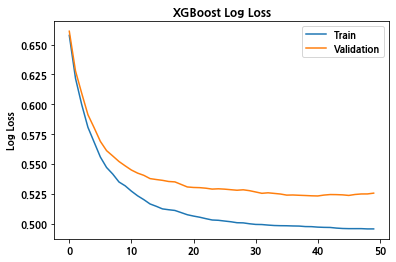

In [60]:
# 모델 성능 시각화

from matplotlib import pyplot
# retrieve performance metrics
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
#pyplot.show()
plt.savefig('XGBoost Log Loss.png')

## 4. 우범화물 예측 및 모델 성능 평가

## 4.1 roc_auc_score

In [61]:
# evaluate xgboost model
print("------Evaluating xgboost model------")
# Predict probability
test_pred = xgb_clf.predict_proba(df_validation)[:,1]
# Calculate auc
xgb_auc = roc_auc_score(df_validation_y, test_pred)
print(xgb_auc)

------Evaluating xgboost model------
0.8249171322776315


## 4.2 f1 score

In [62]:
from sklearn.metrics import classification_report, accuracy_score
# evaluate xgboost model
print("------Evaluating xgboost model------")
# Predict label
test_pred = xgb_clf.predict(df_validation)

# Calculate f1 score
print(classification_report(df_validation_y, test_pred))
f1 = f1_score(df_validation_y, test_pred)
print('f1 score : {}'.format(f1))

------Evaluating xgboost model------
              precision    recall  f1-score   support

           0       0.92      0.72      0.81     11804
           1       0.46      0.79      0.58      3564

    accuracy                           0.73     15368
   macro avg       0.69      0.76      0.69     15368
weighted avg       0.81      0.73      0.75     15368

f1 score : 0.5809298983885867


In [63]:
# 검사율에 따른 우범예측 함수 생성

def inspection_performance(predicted_fraud, test_fraud):
    
    # Set default values before a loop
    
    Inspect_Rate = []
    Precision=[]
    Recall=[]
    
    # Create a loop for making confusion matrix at each inspection rate

    for i in range(0,101,1):
        
        # Find the ith value in ascending order.
        threshold = np.percentile(predicted_fraud, i)
        # Precision = number of frauds / number of inspection
        precision = np.mean(test_fraud[predicted_fraud >= threshold])
        # Recall = number of inspected frauds / number of frauds
        recall = sum(test_fraud[predicted_fraud >= threshold])/sum(test_fraud)
        # Save values
        Inspect_Rate.append(100-i)
        Precision.append(precision)
        Recall.append(recall)
        
    
    compiled_conf_matrix = pd.DataFrame({
        
        'Inspect_Rate':Inspect_Rate,
        'Precision':Precision,
        'Recall':Recall
    })

    return compiled_conf_matrix

In [64]:
# 검사율에 따른 우범예측 
basic_performance = inspection_performance(test_pred, df_validation_y.astype(float))

In [65]:
# 검사율 1~10% 지정 시 Precision 및 Recall 분석
# Precision (적중률) = (검사선별된 우범건수)/(검사선별 건수)
# Recall (적발률) = (검사선별된 우범건수) / (전체 우범건수)
basic_performance.iloc[range(99,89,-1),:]

,Inspect_Rate,Precision,Recall
99,1,0.458003,0.794052
98,2,0.458003,0.794052
97,3,0.458003,0.794052
96,4,0.458003,0.794052
95,5,0.458003,0.794052
94,6,0.458003,0.794052
93,7,0.458003,0.794052
92,8,0.458003,0.794052
91,9,0.458003,0.794052
90,10,0.458003,0.794052


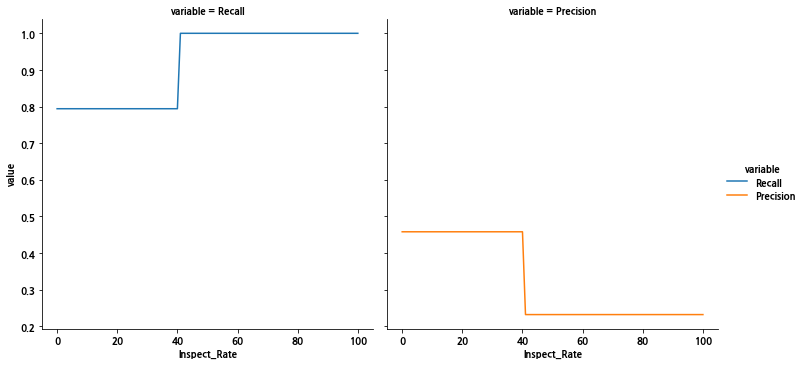

In [66]:
# 검사선별률에 따른 적중률 및 적발률 시각화
data = pd.melt(basic_performance, 
               id_vars = ['Inspect_Rate'],
               value_vars = ['Recall','Precision'])

sns.relplot(data=data,
            kind='line',
            x="Inspect_Rate", 
            y="value", 
            hue='variable',
            col="variable")
plt.savefig('recall & precision.png')


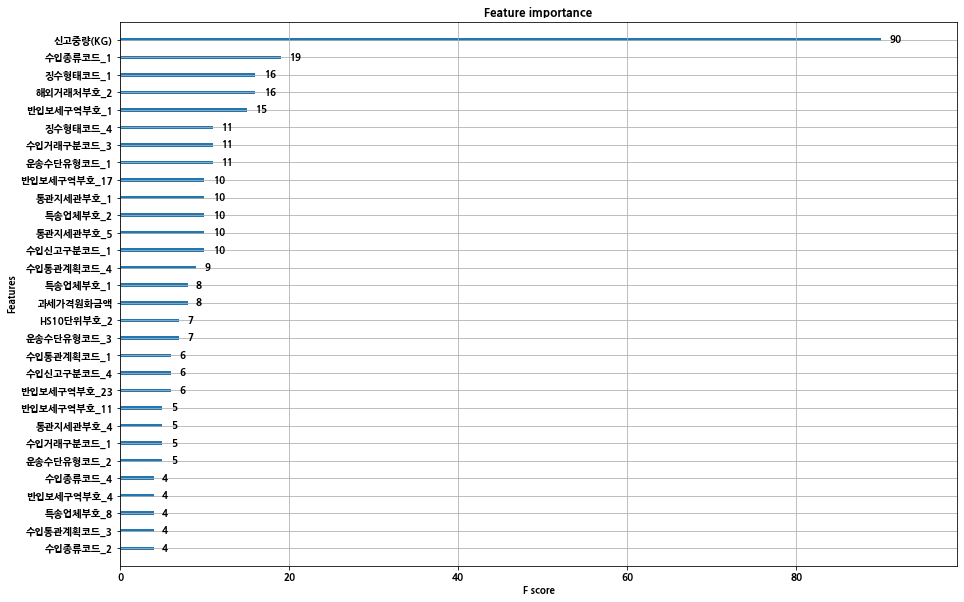

In [67]:
# 모델에 기여도가 높은 변수 시각화
from xgboost import plot_importance
plt.rcParams["font.family"] = 'NanumGothicOTF'
plt.rcParams["figure.figsize"] = (15,10)
plot_importance(xgb_clf, max_num_features=30)
plt.show()

## 5. 제출

In [68]:
# 실제 예측 test 
pred_test = xgb_clf.predict(df_test)
print('test data 개수 : {}'.format(len(pred_test)))

test data 개수 : 23163


In [69]:
submission = pd.read_excel('./data/submission.xlsx')

In [70]:
submission.columns

Index(['신고번호', '우범여부'], dtype='object')

In [71]:
submission['우범여부'] = pred_test
submission.to_excel('냥소영과아이들.xlsx', index=False)